# Pick and Place Tutorial

We'll show pick and place demo on a panda robot.  

In [1]:
import numpy as np
import sys, os
import trimesh
%matplotlib inline

pykin_path = os.path.dirname(os.getcwd())
sys.path.append(pykin_path)

from pykin.robots.single_arm import SingleArm
from pykin.kinematics.transform import Transform
from pykin.collision.collision_manager import CollisionManager
from pykin.tasks.grasp import GraspManager, GraspStatus
import pykin.utils.plot_utils as plt

In [2]:
file_path = '../asset/urdf/panda/panda.urdf'
robot = SingleArm(file_path, Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0.913]))
robot.setup_link_name(eef_name="panda_right_hand")

init_qpos = [0.0, np.pi/6, 0.0, -np.pi*12/24, 0.0, np.pi*5/8,0.0]
fk = robot.forward_kin(np.array(init_qpos))

In [3]:
mesh_path = pykin_path+"/asset/urdf/panda/"
c_manager = CollisionManager(mesh_path)
c_manager.setup_robot_collision(robot, fk)

In [4]:
o_manager = CollisionManager()
obs_pos1 = Transform(pos=np.array([0.6, 0.2, 0.77]), rot=np.array([0, np.pi/2, np.pi/2]))
obs_pos2 = Transform(pos=np.array([0.6, -0.2, 0.77]), rot=np.array([0, np.pi/2, 0]))
obs_pos3 = Transform(pos=np.array([0.4, 0.24, 0.0]))

obj_mesh1 = trimesh.load(pykin_path+'/asset/objects/meshes/square_box.stl')
obj_mesh2 = trimesh.load(pykin_path+'/asset/objects/meshes/box_goal.stl')
obj_mesh3 = trimesh.load(pykin_path+'/asset/objects/meshes/custom_table.stl')

obj_mesh1.apply_scale(0.001)
obj_mesh2.apply_scale(0.001)
obj_mesh3.apply_scale(0.01)

o_manager.add_object("can", gtype="mesh", gparam=obj_mesh1, transform=obs_pos1.h_mat)
o_manager.add_object("box", gtype="mesh", gparam=obj_mesh2, transform=obs_pos2.h_mat)
o_manager.add_object("table", gtype="mesh", gparam=obj_mesh3, transform=obs_pos3.h_mat)

configures = {}
configures["gripper_names"] = ["right_gripper", "leftfinger", "rightfinger", "tcp"]
configures["gripper_max_width"] = 0.08
configures["gripper_max_depth"] = 0.035
configures["tcp_position"] = np.array([0, 0, 0.097])

In [5]:
grasp_man = GraspManager(
    robot, 
    c_manager, 
    o_manager, 
    mesh_path,    
    retreat_distance=0.15,
    release_distance=0.01,
    **configures)

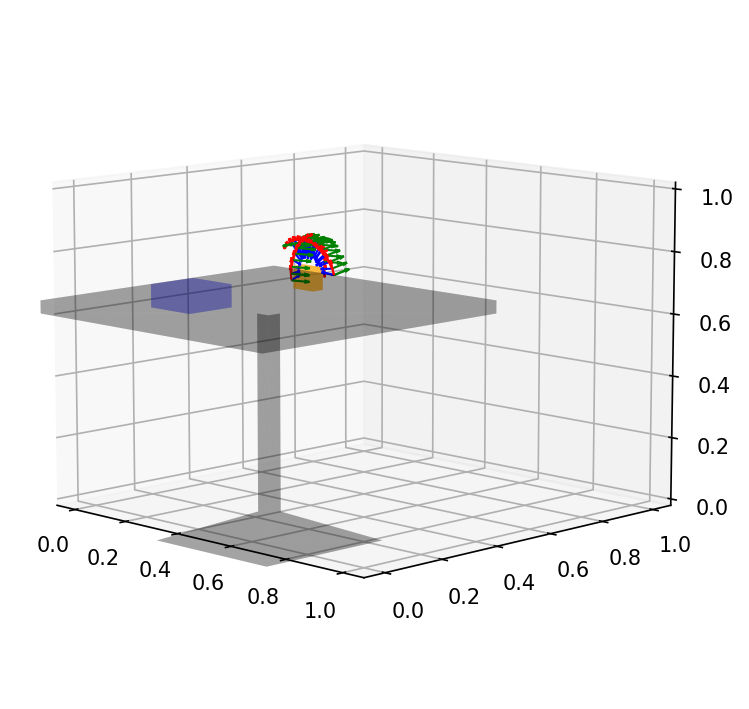

In [6]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=150)
ax.view_init(10, -45)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
grasp_poses = grasp_man.generate_grasps(obj_mesh1, obs_pos1.h_mat, limit_angle=0.5, num_grasp=1, n_trials=30)

for i, (eef_pose, gripper) in enumerate(grasp_poses):
    grasp_man.visualize_axis(ax, eef_pose, axis=[1,1,1], scale=0.05)


[INFO] [Grasp]: Success to get grasp pose.



Iterators : 484
WorkingTime[inverse_kinematics]: 0.9725 sec

Iterators : 14
WorkingTime[inverse_kinematics]: 0.0239 sec

Iterators : 21
WorkingTime[inverse_kinematics]: 0.0414 sec



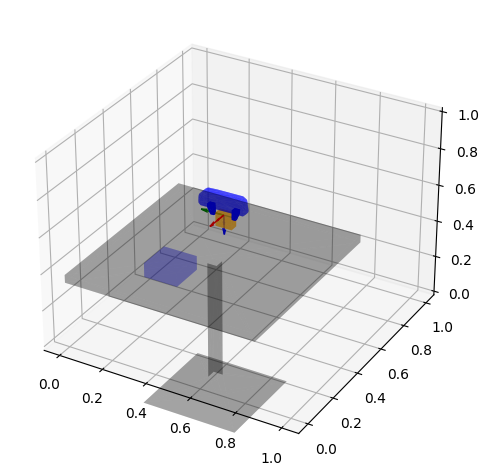

In [13]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=100)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
grasp_pose = grasp_man.get_grasp_pose(obj_mesh1, obs_pos1.h_mat, limit_angle=0.1, num_grasp=10, n_trials=10)
grasp_man.visualize_axis(ax, grasp_man.tcp_pose, axis=[1,1,1], scale=0.05)
gripper = grasp_man.get_gripper_transformed(grasp_man.tcp_pose)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.tcp_pose, axis=[1,1,1], scale=0.1)
plt.plot_line(ax, grasp_man.contact_points, 1)

Iterators : 500
WorkingTime[inverse_kinematics]: 0.9508 sec

Iterators : 500
WorkingTime[inverse_kinematics]: 0.8094 sec

Iterators : 10
WorkingTime[inverse_kinematics]: 0.0174 sec



[INFO] [Grasp]: Success to get grasp pose.



Iterators : 500
WorkingTime[inverse_kinematics]: 0.8409 sec

Iterators : 14
WorkingTime[inverse_kinematics]: 0.0260 sec

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0360 sec



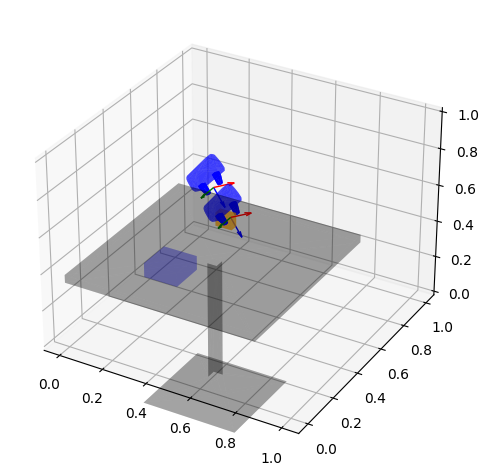

In [12]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=100)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
waypoints = grasp_man.get_grasp_waypoints(obj_mesh1, obs_pos1.h_mat, limit_angle=0.1, num_grasp=10, n_trials=10)
pre_grasp_pose = waypoints[GraspStatus.pre_grasp_pose]
grasp_pose = waypoints[GraspStatus.grasp_pose]

gripper = grasp_man.get_gripper_transformed(pre_grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_grasp_pose), axis=[1,1,1], scale=0.1)
gripper = grasp_man.get_gripper_transformed(grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(grasp_pose), axis=[1,1,1], scale=0.1)
plt.show_figure()

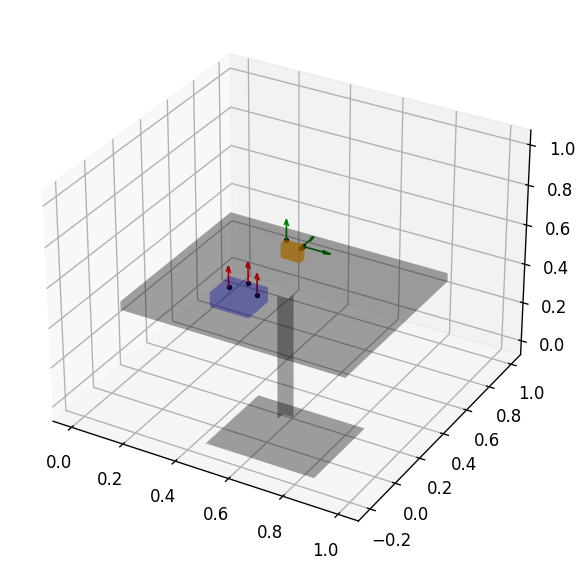

In [9]:
fig, ax = plt.init_3d_figure(figsize=(10,6), dpi=120)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
for point, normal in grasp_man.generate_points_on_support(obj_mesh2, obs_pos2.h_mat, n_samples=3):
    plt.plot_vertices(ax, point)
    plt.plot_normal_vector(ax, point, normal, scale=0.1)

for point, normal in grasp_man.generate_points_for_support(obj_mesh1, obs_pos1.h_mat, n_samples=3):
    plt.plot_vertices(ax, point)
    plt.plot_normal_vector(ax, point, normal, scale=0.1, edgecolor="green")
plt.show_figure()

In [10]:
grasp_waypoints = grasp_man.get_grasp_waypoints(obj_mesh1, obs_pos1.h_mat, limit_angle=0.05, num_grasp=10, n_trials=10)
release_waypoints = grasp_man.get_release_waypoints(obj_mesh2, obs_pos2.h_mat, 10, obj_mesh1, obs_pos1.h_mat, 10, n_trials=10)

pre_grasp_pose = grasp_waypoints[GraspStatus.pre_grasp_pose]
grasp_pose = grasp_waypoints[GraspStatus.grasp_pose]

pre_release_pose = release_waypoints[GraspStatus.pre_release_pose]
release_pose = release_waypoints[GraspStatus.release_pose]

[INFO] [Grasp]: Success to get grasp pose.

[WARNING] [Grasp]: Not found support point
[WARNING] [Grasp]: Not found support point
[WARNING] [Grasp]: Not found support point


Iterators : 500
WorkingTime[inverse_kinematics]: 0.8479 sec

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0332 sec

Iterators : 35
WorkingTime[inverse_kinematics]: 0.0597 sec

Iterators : 13
WorkingTime[inverse_kinematics]: 0.0236 sec



[INFO] [Grasp]: Success to get release pose.



Iterators : 26
WorkingTime[inverse_kinematics]: 0.0526 sec



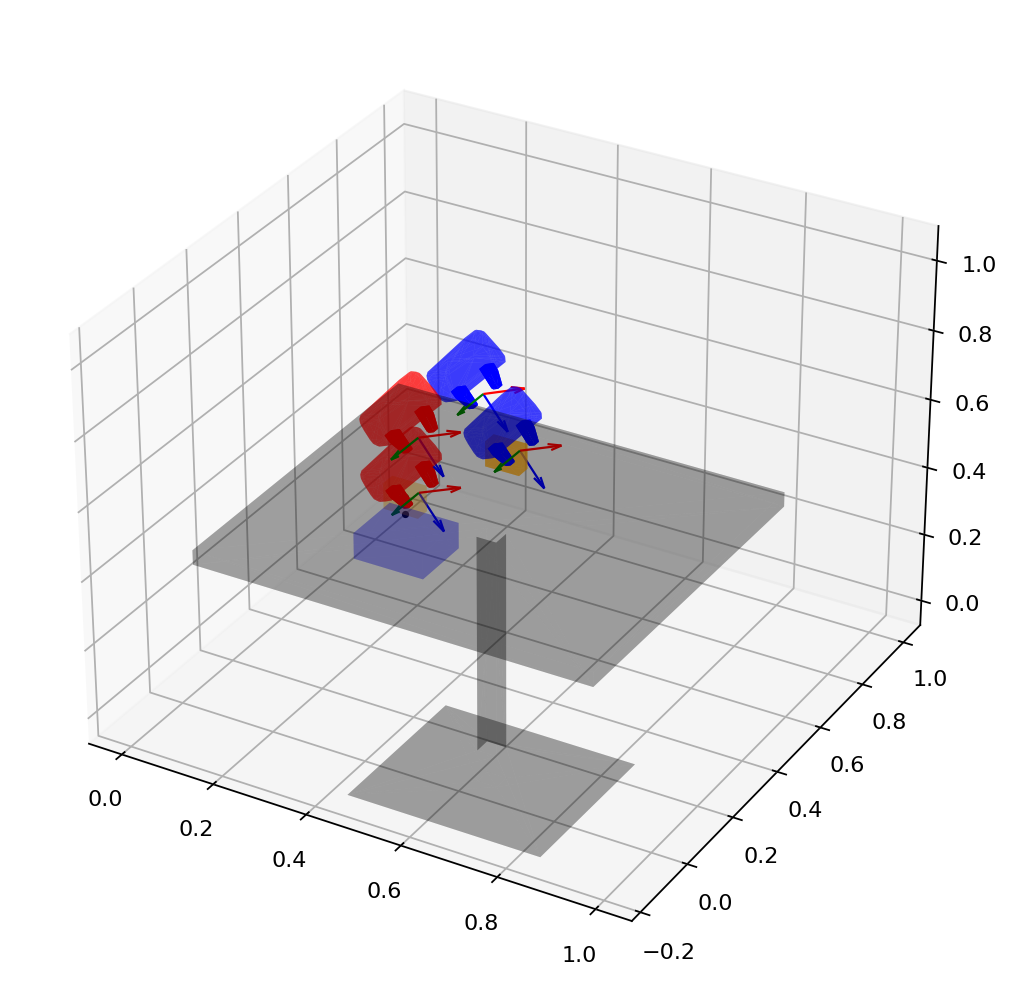

In [11]:
fig, ax = plt.init_3d_figure(figsize=(12,8), dpi=160)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)

pre_grasp_gripper = grasp_man.get_gripper_transformed(pre_grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, pre_grasp_gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_grasp_pose), axis=[1,1,1], scale=0.1)

grasp_gripper = grasp_man.get_gripper_transformed(grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, grasp_gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(grasp_pose), axis=[1,1,1], scale=0.1)

pre_release_gripper = grasp_man.get_gripper_transformed(grasp_man.pre_release_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, pre_release_gripper, alpha=0.5, color='red')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_release_pose), axis=[1,1,1], scale=0.1)

release_gripper = grasp_man.get_gripper_transformed(release_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, release_gripper, alpha=0.5, color='red')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(release_pose), axis=[1,1,1], scale=0.1)

plt.plot_vertices(ax, grasp_man.obj_center_point)
plt.plot_vertices(ax, grasp_man.obj_support_point)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=grasp_man.result_obj_pose, alpha=0.2, color='orange')